In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('../../Data/OASIS/oasis_3.csv')
print(df.shape)

(2168, 22)


In [3]:
df.head()

,Subject,MR ID,id,Age,M/F,dx1,mmse,cdr,apoe,TOTAL_HIPPOCAMPUS_VOLUME,...,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
0,OAS30001,OAS30001_MR_d3132,OAS30001_Freesurfer53_d3132,73.0,F,Cognitively normal,30.0,0.0,23.0,6861.9,...,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
1,OAS30001,OAS30001_MR_d0129,OAS30001_Freesurfer53_d0129,65.0,F,Cognitively normal,30.0,0.0,23.0,7678.9,...,187528.786036,379446.180091,50687.0,517683.180091,8.105851e+05,184600.488060,182662.445419,367262.933479,70168.1,69483.8
2,OAS30001,OAS30001_MR_d2430,OAS30001_Freesurfer53_d2430,71.0,F,Cognitively normal,30.0,0.0,23.0,7105.9,...,178872.680224,357784.489639,49058.0,487405.489639,7.779313e+05,175955.968883,178172.812666,354128.781549,67905.7,68000.2
3,OAS30001,OAS30001_MR_d0757,OAS30001_Freesurfer53_d0757,67.0,F,Cognitively normal,29.0,0.0,23.0,7648.2,...,177566.874682,362040.150904,50071.0,500699.150904,7.993419e+05,185224.779932,188151.990316,373376.770247,69142.3,68558.8
4,OAS30002,OAS30002_MR_d2345,OAS30002_Freesurfer53_d2345,73.0,M,Cognitively normal,29.0,0.0,34.0,7833.2,...,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3


## Data Preprocessing

In [4]:
df = df.dropna(axis=1, how='all') # Drop any empty columns
df = df.dropna(axis=0, how='any') # Drop any rows with empty values 
df = df.rename(columns={'id':'Freesurfer ID', 'dx1':'Diagnosis', 
                        'TOTAL_HIPPOCAMPUS_VOLUME':'TotalHippocampusVol'}) # Rename columns
df = df.drop_duplicates(subset='Subject', keep='first') # Keep only the first visit; this is possible because
                                                        # df is sorted by age
df = df.reset_index(drop=True) # Reset the index
df = df.set_index('Subject')
cols = df.columns.tolist()
cols[2], cols[4] = cols[4], cols[2]
df = df[cols]
df.loc[df['cdr'] < 0.5, 'Diagnosis'] = 'control'
df.loc[~(df['cdr'] < 0.5), 'Diagnosis'] = 'dementia'
df['Diagnosis'].replace(['control','dementia'], [-1,1], inplace=True)
df['M/F'].replace(['M','F'], [0,1], inplace=True)
df = df.drop(['MR ID', 'Freesurfer ID', 'cdr'], axis=1) # Drop categorical and redundant columns

In [5]:
df.head()

,Diagnosis,M/F,Age,mmse,apoe,TotalHippocampusVol,IntraCranialVol,lhCortexVol,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
Subject,,,,,,,,,,,,,,,,,,
OAS30001,-1,1,73.0,30.0,23.0,6861.9,1.186091e+06,181943.698754,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
OAS30002,-1,0,73.0,29.0,34.0,7833.2,1.714636e+06,227101.503019,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3
OAS30003,-1,1,66.0,29.0,33.0,7983.5,1.405092e+06,204825.718573,209641.219733,414466.938306,59379.0,557900.938306,9.299305e+05,213905.159729,222232.368895,436137.528624,76695.5,78697.9
OAS30004,-1,1,61.0,30.0,23.0,8525.1,1.443177e+06,213861.671106,206884.661369,420746.332475,53910.0,566477.332475,9.709780e+05,242595.702097,233016.992108,475612.694206,87710.1,84634.9
OAS30005,-1,1,54.0,30.0,33.0,9298.2,1.554566e+06,225743.655875,224311.450543,450055.106418,63545.0,611117.106418,9.867349e+05,229534.963360,230927.823126,460462.786487,82224.0,81421.3


<AxesSubplot:xlabel='Diagnosis', ylabel='count'>

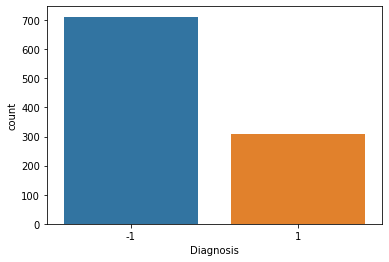

In [6]:
sns.countplot(x='Diagnosis', data=df)

In [7]:
# standard z score scaling
def scale(X):
    u = np.mean(X)
    s = np.std(X)
    X_scaled = (X-u)/s
    return X_scaled

## SVM Model

In [8]:
class SVM:
    # Larger lambda gives a wider margin and smaller lambda results in the narrow margin
    # for infinitely small λ the SVM becomes hard margin
    def __init__(self, learning_rate=0.001, lambd=0.01, iterations=1000, verbose=False):
        self.lambd = lambd
        self.learning = learning_rate
        self.iterations = iterations
        self.w = None
        self.b = None
        self.losses = []
        self.verbose = verbose

    def fit(self, X, y):
        
        self.w = np.random.normal(size=X.shape[1])
        self.b = np.random.normal()
        
        y_np = np.array(y)

        for i in (tqdm(range(self.iterations)) if self.verbose else range(self.iterations)):
            tot_loss = 0
            for idx, xi in enumerate(X):
                #print(idx, xi)
                loss = max(0, 1-(y_np[idx] * (np.dot(self.w, xi) - self.b)))
                tot_loss += loss
                if y_np[idx] * (np.dot(self.w, xi) - self.b) >= 1:
                    dw = 2 * self.lambd * self.w
                    #dw = 2 * 1/(i+1) * self.w
                    db = 0
                    self.w -= self.learning * dw.astype(float)
                    self.b -= self.learning * float(db)
                else:
                    dw = 2 * self.lambd * self.w - np.dot(y_np[idx], xi)
                    #dw = 2 * 1/(i+1) * self.w - np.dot(y_np[idx], xi)
                    db = y_np[idx]
                    self.w -= self.learning * dw.astype(float)
                    self.b -= self.learning * float(db)
            self.losses.append(tot_loss)

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

# PCA
* https://jeremykun.com/2012/06/28/principal-component-analysis/
* https://www.youtube.com/watch?v=52d7ha-GdV8
* https://sebastianraschka.com/Articles/2015_pca_in_3_steps.html

### How PCA works

In [9]:
"""
Load and scale the data along the standard z-score scale
"""
X = df.drop(['Diagnosis'], axis=1)
y = df['Diagnosis']
X_std = scale(X)
X_std.head()

,M/F,Age,mmse,apoe,TotalHippocampusVol,IntraCranialVol,lhCortexVol,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
Subject,,,,,,,,,,,,,,,,,
OAS30001,0.890496,0.241677,0.639286,-2.047473,-0.226531,-1.719480,-0.829346,-1.060639,-0.949387,-0.369293,-0.954014,-1.380694,-1.220170,-1.301636,-1.264824,-1.309048,-1.374532
OAS30002,-1.122970,0.241677,0.373697,0.342734,0.548234,1.147561,1.088129,1.170360,1.134805,-0.109337,1.030542,1.271317,0.902882,1.058231,0.983635,0.567580,0.849847
OAS30003,0.890496,-0.512009,0.373697,0.125442,0.668121,-0.531532,0.142262,0.290108,0.217039,-0.028428,0.185152,0.109728,0.075130,0.301390,0.188915,-0.210435,0.005431
OAS30004,0.890496,-1.050357,0.639286,-2.047473,1.100132,-0.324939,0.525944,0.172314,0.351453,-0.198224,0.331412,0.501246,1.015181,0.654291,0.837196,1.119700,0.717102
OAS30005,0.890496,-1.804043,0.639286,0.125442,1.716801,0.279278,1.030472,0.916997,0.978825,0.100914,1.092687,0.651538,0.587243,0.585928,0.588396,0.457192,0.331886


In [10]:
"""
Eigenvectors and eigenvalues of the covariance matrix is essentially the "core" of PCA
- The eigenvectors, or principal components, determine the directions of the new feature space
- The eigenvalues explain the variance of the data along the new feature axes
"""
np.set_printoptions(suppress=True, precision=3, linewidth=200)
cov = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.165 -0.362 -0.199  0.1    0.056  0.041  0.865 -0.078  0.103  0.146  0.009 -0.003 -0.026  0.007 -0.002  0.    -0.   ]
 [ 0.101  0.477  0.196 -0.264 -0.367 -0.322  0.385  0.452 -0.119 -0.217  0.005  0.001 -0.03   0.004 -0.007 -0.    -0.   ]
 [-0.08  -0.454  0.155 -0.227 -0.381 -0.655 -0.105 -0.347  0.024  0.077  0.013 -0.007 -0.013 -0.001  0.004  0.     0.   ]
 [ 0.     0.087 -0.283  0.818 -0.438 -0.191 -0.08   0.09   0.004  0.009  0.003 -0.001 -0.     0.004 -0.006  0.     0.   ]
 [-0.188 -0.454  0.065  0.01   0.116 -0.085 -0.127  0.797  0.107  0.259  0.008  0.002  0.053  0.01  -0.     0.    -0.   ]
 [-0.241  0.373  0.089 -0.032 -0.033 -0.051  0.053 -0.094  0.692  0.49   0.004 -0.004 -0.068  0.215  0.09   0.     0.   ]
 [-0.292 -0.105  0.215  0.073 -0.141  0.18   0.095 -0.024  0.013 -0.218 -0.469  0.086  0.084  0.009  0.583 -0.038 -0.409]
 [-0.293 -0.087  0.222  0.069 -0.131  0.188  0.09  -0.043  0.013 -0.21   0.459 -0.114  0.248  0.386 -0.381 -0.038 -0.407]
 [-0.294 -

In [11]:
"""
Eigenvectors with the lowest eigenvalues represents those that can be dropped, since they 
reveal the least information about the distribution of the data (lowest variance)
"""
# Pair up the eigenvectors and eigenvalues as (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs.T[i,:]) for i in range(len(eig_vals))]

# Sort the tuples in descending order
eig_pairs.sort(key=lambda x: x[0], reverse=True)


# Print out the eigenvalue and eigenvector pairs
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print('%.5f %s' % (i[0], i[1]))

Eigenvalues in descending order:
10.00378 [ 0.165  0.101 -0.08   0.    -0.188 -0.241 -0.292 -0.293 -0.294 -0.07  -0.299 -0.309 -0.281 -0.281 -0.282 -0.298 -0.298]
1.96502 [-0.362  0.477 -0.454  0.087 -0.454  0.373 -0.105 -0.087 -0.096 -0.06  -0.094  0.086  0.042  0.055  0.049  0.117  0.116]
1.27874 [-0.199  0.196  0.155 -0.283  0.065  0.089  0.215  0.222  0.219 -0.58   0.111 -0.029 -0.317 -0.321 -0.32   0.06   0.055]
1.05335 [ 0.1   -0.264 -0.227  0.818  0.01  -0.032  0.073  0.069  0.071 -0.416  0.01   0.01  -0.053 -0.049 -0.051  0.029  0.031]
0.77083 [ 0.056 -0.367 -0.381 -0.438  0.116 -0.033 -0.141 -0.131 -0.137 -0.546 -0.17   0.055  0.2    0.207  0.204  0.016  0.014]
0.67468 [ 0.041 -0.322 -0.655 -0.191 -0.085 -0.051  0.18   0.188  0.185  0.372  0.213 -0.07  -0.211 -0.203 -0.208 -0.005  0.003]
0.53241 [ 0.865  0.385 -0.105 -0.08  -0.127  0.053  0.095  0.09   0.093 -0.092  0.036  0.094  0.036  0.032  0.034  0.097  0.095]
0.31694 [-0.078  0.452 -0.347  0.09   0.797 -0.094 -0.024 -0.04

In [12]:
"""
To calculate the number of principal components to use for our feature subspace, we 
can look at the "explained variance". This value can be calculated from the eigenvalues, 
and tells us how much variance can be attributed to each of the principal components
"""
total = sum(eig_vals)
explained_variance = [(i / total) for i in sorted(eig_vals, reverse=True)]
explained_variance = 100 * np.array(explained_variance)
cumulative_explained_variance = np.cumsum(explained_variance)

for i, value in enumerate(cumulative_explained_variance):
    print(f'Top {i+1} component(s) captures {value}% of the variance')

Top 1 component(s) captures 58.78816002545999% of the variance
Top 2 component(s) captures 70.33579220577562% of the variance
Top 3 component(s) captures 77.85044358681071% of the variance
Top 4 component(s) captures 84.04057678384474% of the variance
Top 5 component(s) captures 88.5704143852802% of the variance
Top 6 component(s) captures 92.535239673912% of the variance
Top 7 component(s) captures 95.66399205071964% of the variance
Top 8 component(s) captures 97.52653820460894% of the variance
Top 9 component(s) captures 98.64007316537968% of the variance
Top 10 component(s) captures 99.55330938350042% of the variance
Top 11 component(s) captures 99.7287150618171% of the variance
Top 12 component(s) captures 99.82702257424695% of the variance
Top 13 component(s) captures 99.90769623398398% of the variance
Top 14 component(s) captures 99.97629018534113% of the variance
Top 15 component(s) captures 100.00000000000006% of the variance
Top 16 component(s) captures 100.00000000000006% of 

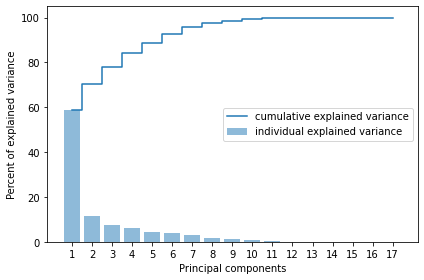

In [13]:
plt.figure(figsize=(6, 4))

plt.bar(range(1,explained_variance.shape[0]+1), explained_variance, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1,cumulative_explained_variance.shape[0]+1), cumulative_explained_variance, where='mid',
         label='cumulative explained variance')
plt.ylabel('Percent of explained variance')
plt.xlabel('Principal components')
plt.legend(loc='center right')
plt.xticks(range(1,explained_variance.shape[0]+1))
plt.tight_layout()

### PCA implementation

In [14]:
class PCA:
    
    def __init__(self, top_k=None):
        """
        Intializes the PCA class
        :param top_k: the number used when PCA picks the top k eigenvectors to use, 
                      None if the PCA will decide by itself
        :principal_components: will store the principal components to be used
        """
        self.top_k = top_k
        self.principal_components = None
    
    def fit(self, X, standardized=False, threshold=0.95):
        """
        Fits the PCA by finding and storing the top k eigenvectors
        :param X: n x d dataset, where d represents the number of features.
        :param standardized: boolean, tells if the dataset X is standardized or not
        :param threshold: the explained variance threshold to select the top_k value
        """
        # Standardize the data, if it's not standardized
        if not standardized:
            X = scale(X)
        
        # Create the covariance matrix
        cov = np.cov(X.T)
        
        # Perform eigendecomposition on the covariance matrix
        eig_vals, eig_vecs = np.linalg.eig(cov)
        
        # If top_k value was inputted, we compute it ourselves based on the data
        if self.top_k == None:
            # Find the best number of components that pass the threshold
            if threshold > 1:
                threshold /= 100
            total = sum(eig_vals)
            explained_variance = [(i / total) for i in sorted(eig_vals, reverse=True)]
            cumulative_explained_variance = np.cumsum(explained_variance)
            self.top_k = np.argmax(cumulative_explained_variance > threshold) + 1
        
        # Pair up the eigenvectors and eigenvalues as (eigenvalue, eigenvector) tuples
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs.T[i,:]) for i in range(len(eig_vals))]

        # Sort the tuples in descending order
        eig_pairs.sort(key=lambda x: x[0], reverse=True)

        self.principal_components = np.array([pair[1] for pair in eig_pairs[0:self.top_k]])
        
    def transform(self, X, standardized=False):
        """
        Project the data onto the new feature space
        :param X: n x d dataset, where d represents the number of features.
        :param standardized: boolean, tells if the dataset X is standardized or not
        :return X_pca: the resulting transformed dataset
        """
        if not standardized:
            X = scale(X)
        X_pca = np.dot(X, self.principal_components.T)
        return X_pca
    
    def scale(X):
        u = np.mean(X)
        s = np.std(X)
        X_scaled = (X-u)/s
        return X_scaled

In [15]:
pca = PCA()
pca.fit(X, threshold=0.99)

In [16]:
print(pca.principal_components)

[[ 0.165  0.101 -0.08   0.    -0.188 -0.241 -0.292 -0.293 -0.294 -0.07  -0.299 -0.309 -0.281 -0.281 -0.282 -0.298 -0.298]
 [-0.362  0.477 -0.454  0.087 -0.454  0.373 -0.105 -0.087 -0.096 -0.06  -0.094  0.086  0.042  0.055  0.049  0.117  0.116]
 [-0.199  0.196  0.155 -0.283  0.065  0.089  0.215  0.222  0.219 -0.58   0.111 -0.029 -0.317 -0.321 -0.32   0.06   0.055]
 [ 0.1   -0.264 -0.227  0.818  0.01  -0.032  0.073  0.069  0.071 -0.416  0.01   0.01  -0.053 -0.049 -0.051  0.029  0.031]
 [ 0.056 -0.367 -0.381 -0.438  0.116 -0.033 -0.141 -0.131 -0.137 -0.546 -0.17   0.055  0.2    0.207  0.204  0.016  0.014]
 [ 0.041 -0.322 -0.655 -0.191 -0.085 -0.051  0.18   0.188  0.185  0.372  0.213 -0.07  -0.211 -0.203 -0.208 -0.005  0.003]
 [ 0.865  0.385 -0.105 -0.08  -0.127  0.053  0.095  0.09   0.093 -0.092  0.036  0.094  0.036  0.032  0.034  0.097  0.095]
 [-0.078  0.452 -0.347  0.09   0.797 -0.094 -0.024 -0.043 -0.034  0.056  0.01  -0.043  0.004  0.014  0.009 -0.063 -0.064]
 [ 0.103 -0.119  0.024  

In [17]:
X_pca = pca.transform(X)

### Evaluating PCA

In [18]:
X_pca.shape, X.shape

((1022, 10), (1022, 17))

In [29]:
def test_pca(dataset, data_y, data_type):
    print(f'Data Type: {data_type}')
    X_train, X_test, y_train, y_test = train_test_split(dataset, data_y, test_size=0.2, random_state=32)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    X_train = scale(X_train)
    X_test = scale(X_test)
    model = SVM(verbose=True)
    model.fit(np.array(X_train), y_train)
    predictions = model.predict(X_test)
    correct_preds = np.sum(predictions == y_test)
    print(f'Accuracy: {correct_preds/y_test.size}')

In [30]:
# Original dataset
test_pca(X, y, "Original")

Data Type: Original
(817, 17) (205, 17) (817,) (205,)


  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.8829268292682927


In [31]:
# PCA-transformed dataset
test_pca(X_pca, y, "My PCA")

Data Type: My PCA
(817, 10) (205, 10) (817,) (205,)


  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.9073170731707317


In [32]:
# Testing with sklearn to compare
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=10)
# Since sklearn doesn't standardize, we'll have to do it beforehand
X_sk_std = scale(X)
X_pca_sklearn = sklearn_pca.fit_transform(X_sk_std)

In [33]:
# PCA-transformed dataset
test_pca(X_pca_sklearn, y, "SKLearn PCA")

Data Type: SKLearn PCA
(817, 10) (205, 10) (817,) (205,)


  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.8975609756097561
